## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/planet/'

In [4]:
# Data preparation steps if you are using Crestle:

os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('/cache/planet/tmp', exist_ok=True)

!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
#
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/test-jpg {PATH}
#
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
!ln -s /cache/planet/tmp {PATH}

ln: failed to create symbolic link 'data/planet/train-jpg': File exists
ln: failed to create symbolic link 'data/planet/test-jpg': File exists
ln: failed to create symbolic link 'data/planet/train_v2.csv': File exists
ln: failed to create symbolic link 'data/planet/tmp': File exists


In [5]:
ls {PATH}

models/  test-jpg@  tmp@  train-jpg@  train_v2.csv@


## Multi-label versus single-label classification

In [6]:
from fastai.plots import *

In [7]:
def get_1st(path): return glob(f'{path}/*.*')[0]

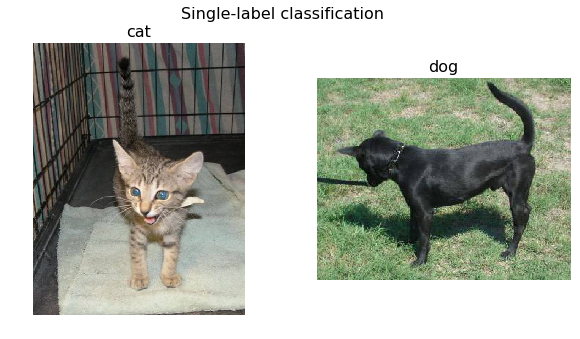

In [8]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

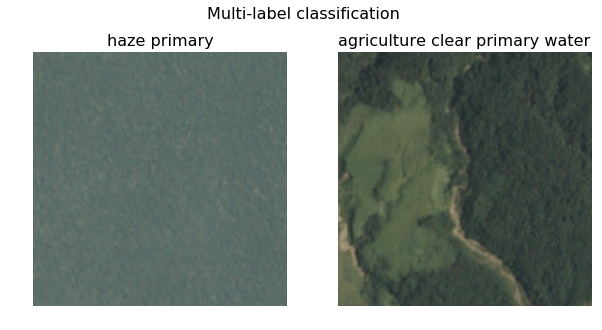

In [9]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [10]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [11]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [12]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [13]:
data = get_data(256)

In [14]:
x,y = next(iter(data.val_dl))

In [15]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [16]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

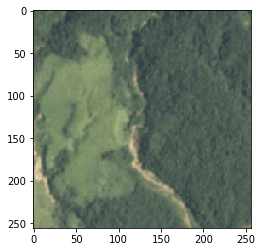

In [17]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [18]:
sz=64

In [19]:
data = get_data(sz)

In [20]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [21]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.216743   0.253183   0.813537  



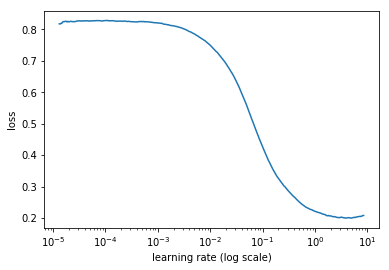

In [22]:
lrf=learn.lr_find()
learn.sched.plot()

In [23]:
lr = 0.2

In [24]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.14531    0.134433   0.881999  
    1      0.143582   0.12853    0.889116                    
    2      0.138219   0.127217   0.889009                    
    3      0.136473   0.127114   0.887702                    
    4      0.133305   0.125938   0.888543                    
    5      0.130145   0.123      0.893443                    
    6      0.130438   0.122646   0.894275                    



[0.12264567, 0.8942754790982641]

In [25]:
lrs = np.array([lr/9,lr/3,lr])

In [26]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.118951   0.109649   0.908781  
    1      0.115974   0.106522   0.910792                    
    2      0.106058   0.10187    0.914942                    
    3      0.11028    0.103777   0.911477                    
    4      0.104999   0.101322   0.914494                    
    5      0.102493   0.097868   0.917074                     
    6      0.09775    0.097676   0.917549                     



[0.09767616, 0.9175492169315694]

In [27]:
learn.save(f'{sz}')

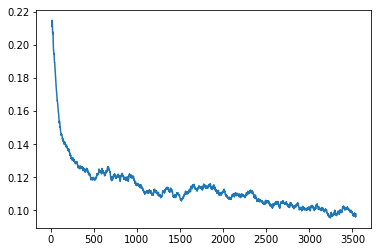

In [28]:
learn.sched.plot_loss()

In [29]:
sz=128

In [30]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.09921    0.096416   0.916178  
    1      0.100293   0.097076   0.915591                     
    2      0.09552    0.095085   0.918618                     
    3      0.096515   0.095388   0.918039                     
    4      0.096882   0.093253   0.92041                      
    5      0.097116   0.093188   0.920153                     
    6      0.097768   0.093243   0.920328                     



[0.093242824, 0.9203278632318145]

In [31]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.094483   0.087602   0.927375  
    1      0.092509   0.089164   0.924986                     
    2      0.091198   0.086194   0.9282                       
    3      0.094967   0.089297   0.924417                     
    4      0.088902   0.086028   0.927702                     
    5      0.086493   0.085125   0.929135                     
    6      0.084526   0.084574   0.929982                     



In [32]:
sz=256

In [33]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.089567   0.089915   0.923365  
    1      0.089912   0.088993   0.924812                     
    2      0.090028   0.08828    0.925985                     
    3      0.089969   0.088441   0.925648                     
    4      0.087625   0.08796    0.926257                     
    5      0.087153   0.086901   0.927408                     
    6      0.087565   0.087297   0.926779                     



[0.08729684, 0.926779293079771]

In [34]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.087297   0.083219   0.929661  
    1      0.090042   0.083804   0.930288                     
    2      0.083275   0.082223   0.932519                     
    3      0.086224   0.083866   0.929887                     
    4      0.08427    0.082713   0.93072                      
    5      0.082344   0.081347   0.932634                     
    6      0.077687   0.081702   0.931922                     



In [35]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [36]:
f2(preds,y)

0.93054978001733

### End